### Centerlines exploration and visualization


- The first part will let you input a model path with the predictions for the segmentations and then compute the centerlines etc to visualize easily within the folder
[visualization](###Visualization)

- The second part is the exploration that led to the first part
[Exploration](###Exploration)

In [98]:
%matplotlib inline
import os
import re

import h5py
import numpy as np

from scipy.ndimage import gaussian_filter


import SimpleITK as sitk
import math
from scipy import interpolate

from matplotlib import pyplot as plt
from skimage.morphology import skeletonize_3d, binary_dilation, dilation, cube

from utils import normalize_image, crop_or_pad_4dvol, crop_or_pad_Bern_slices, normalize_image_new, make_dir_safely

import matplotlib
from utils_centerline import (load_masked_data, show_center_lines,load_cropped_data_sliced, 
load_cropped_data_straightened, extract_slice_from_sitk_image, load_masked_data_sliced,
create_center_lines, show_center_lines)

### Visualization

In [99]:
inf_results_dir = os.getcwd() + '/logdir/inference_results/'
models = os.listdir(inf_results_dir)

models

['unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_True_full_run_bern_32_slices_fine_tuning_lr_1e-3',
 'unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_True_full_run_bern_full_fine_tuning_lr_1e-3',
 'unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_False_full_run_bern_only_w_labels',
 'unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_3_full_run',
 'unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_False_full_run_finetune_lr_1e-3_e20_AdamW_bern_only_w_labels_FG_DICE',
 'unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_False_full_run_finetune_lr_1e-3_AdamW_e40_bern_all_FG_DICE',
 'unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_False_full_run_adaptive_batch_norm_lr_1e-3_e20_bern_all',
 'unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_False_full_run_adaptive_batch_norm_lr_1e-3_e100_bern_only_w_labels',
 'unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_False_full_run_adaptive_batch_norm_lr_scheduler_AdamW_e50_bern_32_train_val_FG_DICE',
 'unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_False_full_run_only_w_labels_adaptative_batch_norm_lr_1e-3_

In [100]:
model = models[31]
print(model)

unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_False_full_run_only_w_labels_e80_lr_1e-3_AdamW_tr_27_


In [101]:
model_path = f'{inf_results_dir}/{model}/controls'
hand_seg_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady/segmenter_rw_pw_hard/controls'

In [102]:
# Only for control (also careful on the dir, cause some models from inference were also applied on the manually segmented ones)
all_seg_paths = [os.path.join(hand_seg_path, f) for f in os.listdir(hand_seg_path)]
all_seg_paths = all_seg_paths + [os.path.join(model_path, f) for f in os.listdir(model_path)]
len(all_seg_paths)

55

In [103]:
from skimage.morphology import skeletonize_3d, dilation, cube, binary_erosion
import SimpleITK as sitk
from scipy import interpolate

In [104]:
def tile_3d(X, rows, cols, every_x_time_step):
    """Tile images for display."""
    tiling = np.zeros((rows * X.shape[1], cols * X.shape[2]), dtype = X.dtype)
    for i in range(rows):
        for j in range(cols):
            img = X[i,:,:,j*every_x_time_step]
            tiling[
                    i*X.shape[1]:(i+1)*X.shape[1],
                    j*X.shape[2]:(j+1)*X.shape[2]] = img
    return tiling


def plot_batch_3d(X, channel, every_x_time_step, out_path):

    """
    This method creates a plot of a batch

    param: X - input of dimensions (batches, x, y, t,  channels)
    param: channel - which channel of the images should be plotted (0-3):(intensity,vx,vy,vz)
    param: every_x_time_step - for 1, all timesteps are plotted, for 2, every second timestep is plotted etc..
    param: out_path - path of the folder where the plots should be saved
    """

    X = np.stack(X)
    X = X[:,:,:,:,channel]

    rows = X.shape[0]
    cols = math.ceil(X.shape[3] // every_x_time_step)
    canvas = tile_3d(X, rows, cols, every_x_time_step)
    canvas = np.squeeze(canvas)

    plt.imsave(out_path, canvas, cmap='gray')


In [105]:
def interpolate_and_slice(image,
                          coords,
                          size, smoothness = 200):


    #coords are a bit confusing in order...
    x = coords[:,0]
    y = coords[:,1]
    z = coords[:,2]

    coords = np.array([z,y,x]).transpose([1,0])

    #convert the image to SITK (here let's use the intensity for now)
    sitk_image = sitk.GetImageFromArray(image[:,:,:])

    # spline parametrization
    params = [i / (size[2] - 1) for i in range(size[2])]
    tck, _ = interpolate.splprep(np.swapaxes(coords, 0, 1), k=3, s=smoothness)

    # derivative is tangent to the curve
    points = np.swapaxes(interpolate.splev(params, tck, der=0), 0, 1)
    Zs = np.swapaxes(interpolate.splev(params, tck, der=1), 0, 1)
    direc = np.array(sitk_image.GetDirection()[3:6])

    slices = []
    for i in range(len(Zs)):
        # I define the x'-vector as the projection of the y-vector onto the plane perpendicular to the spline
        xs = (direc - np.dot(direc, Zs[i]) / (np.power(np.linalg.norm(Zs[i]), 2)) * Zs[i])
        sitk_slice = extract_slice_from_sitk_image(sitk_image, points[i], Zs[i], xs, list(size[:2]) + [1], fill_value=0)
        np_image = sitk.GetArrayFromImage(sitk_slice).transpose(2, 1, 0)
        slices.append(np_image)

    # stick slices together
    return np.concatenate(slices, axis=2)

In [106]:
# These functions are for interpolating the whole aorta
def nearest_neighbors(q,points,num_neighbors=2,exclude_self=True):
    d = ((points-q)**2).sum(axis=1)  # compute distances
    ndx = d.argsort() # indirect sort 
    start_ind = 1 if exclude_self else 0
    end_ind = start_ind+num_neighbors
    ret_inds = ndx[start_ind:end_ind]
    return ret_inds

def calc_angle(v1, v2, reflex=False):
    dot_prod = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    #round dot_prod for numerical stability
    angle = np.arccos(np.around(dot_prod,6))
    
    if (reflex == False):
        return angle
    else:
        return 2 * np.pi - angle
    
def order_points(candidate_points):
    ordered_points = []
    
    #take first point
    ordered_points.append(candidate_points[0])
    nn = nearest_neighbors(ordered_points[-1], candidate_points,num_neighbors=1)
    #take second point
    ordered_points.append(candidate_points[nn[0]])
    #for ind,cp_i in enumerate(candidate_points):
    remove = 0
    while(len(ordered_points)<len(candidate_points)):
        
        #get 10 nearest neighbors of latest point
        nn = nearest_neighbors(ordered_points[-1], candidate_points,num_neighbors=10)
        # Taking the current point and the previous, we compute the angle to the current and eventual neighbourg
        # making sure its acute
        found = 0
        
        for cp_i in nn:
            ang = calc_angle(ordered_points[-2]-ordered_points[-1], candidate_points[cp_i]-ordered_points[-1])
            if ang > (np.pi/2.):
                found =1

                ordered_points.append(candidate_points[cp_i])
            if found == 1:
                break 
        if found ==0:
            if remove >5:
                break
            
            candidate_points = list(candidate_points)
            candidate_points = [arr for arr in candidate_points if not np.array_equal(arr, ordered_points[-1])]
            candidate_points = np.array(candidate_points)
            ordered_points.pop()
            remove += 1
    ordered_points = np.array(ordered_points)

    return(ordered_points)

In [107]:
def skeleton_points(segmented, dilation_k=0, erosion_k = 0):
    # Average the segmentation over time (the geometry should be the same over time)
    avg = np.average(segmented, axis = 3)
    if dilation_k > 0:
        avg = binary_erosion(avg, selem=np.ones((erosion_k, erosion_k,erosion_k)))
        avg = dilation(avg, selem=np.ones((dilation_k, dilation_k,dilation_k)))
        
        
        
    # Compute the centerline points of the skeleton
    skeleton = skeletonize_3d(avg[:,:,:])
   
    # Get the points of the centerline as an array
    points = np.array(np.where(skeleton != 0)).transpose([1,0])

    # Order the points in ascending order with x
    points = points[points[:,0].argsort()[::-1]]
    
    return points
    

def create_center_lines(path, cnn_predictions = True):

    
    img_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady/preprocessed/controls/numpy'

    i = 0
    for n, patient in enumerate(os.listdir(path)):
        name = patient.replace("seg_", "").replace("_.npy", "")

        print("========================================================================")
        print('Loading subject ' + str(n+1) + ' out of ' + str(len(os.listdir(path))) + '...')
        print('Patient\'s name: ' + name)
        print("========================================================================")

        # load the segmentation that was created with Nicolas's tool
        image = np.load(img_path + f'/{patient.replace("seg_", "")}')
        segmented = np.load(path + f'/{patient}')
        
        if cnn_predictions:
            points_ = skeleton_points(segmented, dilation_k = 0)
            points_dilated = skeleton_points(segmented, dilation_k = 4,erosion_k = 4)
        else:
            points_ = skeleton_points(segmented, dilation_k = 0)
            points_dilated = skeleton_points(segmented, dilation_k = 2,erosion_k = 2)
        points = points_dilated.copy()
        # ================================
        # VISUALIZATIONS
        # ================================
        

        exp_path = os.path.join('/',*path.split('/')[:-1])
        
        if not os.path.exists(exp_path + '/SubjectCenterlines/'):
            os.makedirs(exp_path + '/SubjectCenterlines/')
        if not os.path.exists(exp_path + '/SubjectCenterlines_and_interpolation/'):
            os.makedirs(exp_path + '/SubjectCenterlines_and_interpolation/')

        if not os.path.exists(exp_path + '/SubjectCenterlines_and_interpolation_full_aorta/'):
            os.makedirs(exp_path + '/SubjectCenterlines_and_interpolation_full_aorta/')
        


        fig = plt.figure('Centerline')
        fig, ax = plt.subplots(1, 2, figsize=(7, 7))
        axs = ax.ravel()
        axs[0].imshow(image[:,:,15,3,0], cmap='gray')
        axs[0].scatter(points_[:,1],points_[:,0], s=2, c='red', marker='o')
            
        axs[1].imshow(image[:,:,15,3,0], cmap='gray')
        axs[1].scatter(points_dilated[:, 1],points_dilated[:,0], s=2, c='red', marker='o')    
        
        name_save = exp_path + '/SubjectCenterlines/' + f'{name}' +'.png'
        fig.savefig(name_save)
        plt.show()
        plt.close()

        # ================================
        # Limit to sectors where ascending aorta is located
        points_limited = points[np.where(points[:,1]<60)]
        points_limited = points_limited[np.where(points_limited[:,0]<90)]

        # Order the points in ascending order with x
        points_limited = points_limited[points_limited[:,0].argsort()[::-1]]        

        temp_limited = []
        for index, element in enumerate(points_limited[5:]):
            if (index%5)==0:
                temp_limited.append(element)
        coords_limited = np.array(temp_limited)
        #coords_limited are a bit confusing in order...
        x_limited = coords_limited[:,0]
        y_limited = coords_limited[:,1]
        z_limited = coords_limited[:,2]
        
        coords_limited = np.array([z_limited,y_limited,x_limited]).transpose([1,0])
        size_limited = [36, 36, 64, 48, 4] # [x, y, z, t, num_channels]

        # spline parametrization
        params_limited = [i / (size_limited[2] - 1) for i in range(size_limited[2])]
        tck_limited, _ = interpolate.splprep(np.swapaxes(coords_limited, 0, 1), k=3, s=200)
        points_inter_limited = np.swapaxes(interpolate.splev(params_limited, tck_limited, der=0), 0, 1)
        fig1, ax = plt.subplots(1, 2, figsize=(7, 7))
        axs = ax.ravel()
        axs[0].imshow(image[:,:,15,3,0], cmap='gray')
        axs[0].scatter(points_limited[:,1],points_limited[:,0], s=2, c='red', marker='o')
        
        axs[1].imshow(image[:,:,15,3,0], cmap='gray')
        axs[1].scatter(points_inter_limited[:, 1],points_inter_limited[:,2], s=2, c='red', marker='o')    
        name_save = exp_path + '/SubjectCenterlines_and_interpolation/' + f'{name}' +'.png'
        fig1.savefig(name_save)
        plt.show()
        plt.close()

        
        points_order = order_points(points)
        temp = []
        for index, element in enumerate(points_order[5:]):
            if (index%5)==0:
                temp.append(element)

        coords = np.array(temp)
        #print(coords_limited)

        

        x = coords[:,0]
        y = coords[:,1]
        z = coords[:,2]
        coords = np.array([z,y,x]).transpose([1,0])
        size = [36, 36, 256, 48, 4] # [x, y, z, t, num_channels]

        
        # spline parametrization for full aorta
        params = [i / (size[2] - 1) for i in range(size[2])]
        tck, _ = interpolate.splprep(np.swapaxes(coords, 0, 1), k=3, s=10)
        points_inter = np.swapaxes(interpolate.splev(params, tck, der=0), 0, 1)

        fig, ax = plt.subplots(1, 2, figsize=(7, 7))
        axs = ax.ravel()
        axs[0].imshow(image[:,:,15,3,0], cmap='gray')
        axs[0].scatter(points_order[:,1],points_order[:,0], s=2, c='red', marker='o')
        
        axs[1].imshow(image[:,:,15,3,0], cmap='gray')
        axs[1].scatter(points_inter[:, 1],points_inter[:,2], s=2, c='red', marker='o')    
        name_save = exp_path + '/SubjectCenterlines_and_interpolation_full_aorta/' + f'{name}' +'.png'
        plt.show()
        fig.savefig(name_save)
        plt.close()
        
            
            


    return 0


In [109]:
if not os.listdir(os.path.join('/',*model_path.split('/')[:-1])).__contains__('SubjectCenterlines'):
    create_center_lines(model_path, cnn_predictions= True)

In [110]:
def save_all_in_one(model_path):
    save_images_path = os.path.join('/',*model_path.split('/')[:-1])+ '/SubjectCenterlines/'
    image_list = os.listdir(save_images_path)
    image_list.sort()
    n_images = len(image_list)
    print('n_images', n_images)


    fig, ax = plt.subplots(np.ceil(np.sqrt(n_images)).astype(int), np.ceil(np.sqrt(n_images)).astype(int), figsize=(20,20))
    plt.subplots_adjust(wspace=0, hspace=0)
    for i, file in enumerate(image_list):
        img = plt.imread(os.path.join(save_images_path, file))
        ax[i//np.ceil(np.sqrt(n_images)).astype(int), i%np.ceil(np.sqrt(n_images)).astype(int)].imshow(img)
        ax[i//np.ceil(np.sqrt(n_images)).astype(int), i%np.ceil(np.sqrt(n_images)).astype(int)].set_title(file)
        ax[i//np.ceil(np.sqrt(n_images)).astype(int), i%np.ceil(np.sqrt(n_images)).astype(int)].axis('off')

    
    plt.savefig(os.path.join(os.path.join('/',*model_path.split('/')[:-1]), 'all_images_centerlines.png'))
    plt.show()


        

n_images 28


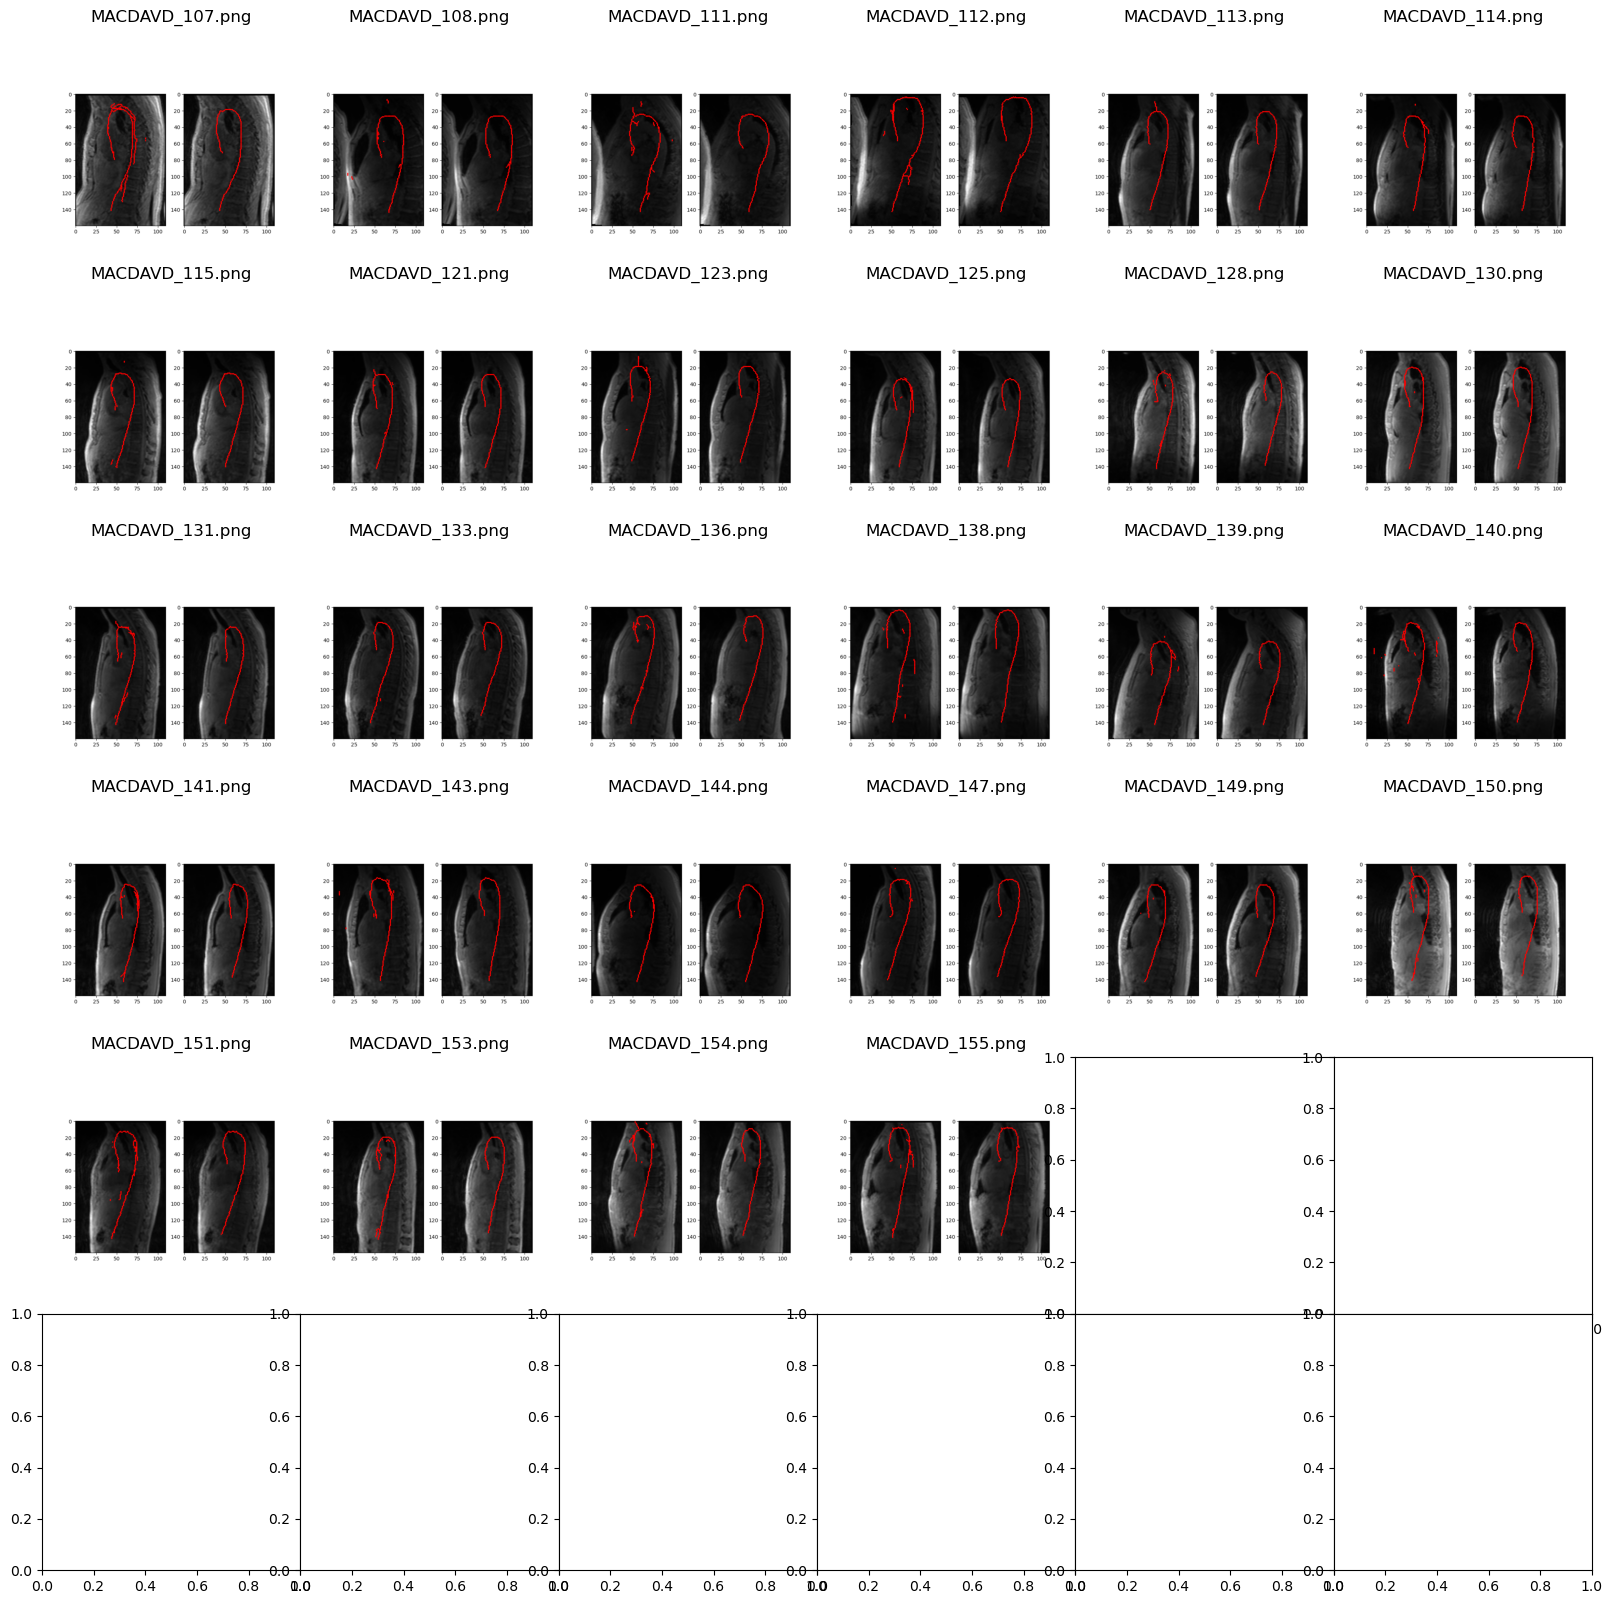

In [111]:
%matplotlib inline
save_all_in_one(model_path=model_path)

In [112]:
def crop_or_pad_Bern_new(data, new_shape):
    print('Check this function!')
    processed_data = np.zeros(new_shape)
    # axis 0 is the x-axis and we crop from top since aorta is at the bottom
    # axis 1 is the y-axis and we crop equally from both sides
    # axis 2 is the z-axis and we crop from the right (end of the image) since aorta is at the left
    delta_axis0 = data.shape[0] - new_shape[0]
    delta_axis1 = data.shape[1] - new_shape[1]
    delta_axis2 = data.shape[2] - new_shape[2]
    if len(new_shape) == 5: # Image
        # The x is always cropped, y always padded, z_cropped
        processed_data[:, :data.shape[1],:,:data.shape[3],... ] = data[delta_axis0:,:new_shape[1], :new_shape[2],...]

    if len(new_shape) == 4: # Label
        # The x is always cropped, y always padded, z_cropped
        processed_data[:, :data.shape[1],:,:data.shape[3],... ] = data[delta_axis0:,:new_shape[1], :new_shape[2],...]
    return processed_data


In [113]:
def prepare_and_write_sliced_data_bern(model_path,
                                       filepath_output,
                           train_test,
                           stack_z = True,
                           cnn_predictions = True):

    # ==========================================
    # Study the the variation in the sizes along various dimensions (using the function 'find_shapes'),
    # Using this knowledge, let us set common shapes for all subjects.
    # ==========================================
    # This shape must be the same in the file where all the training parameters are set!
    # ==========================================
    common_image_shape = [36, 36, 64, 48, 4] # [x, y, z, t, num_channels]

    #network_common_image_shape = [144, 112, None, 48, 4] # [x, y, t, num_channels]

    end_shape = [32, 32, 64, 48, 4]
    # for x and y axes, we can remove zeros from the sides such that the dimensions are divisible by 16
    # (not required, but this makes it nice while training CNNs)
    
    # ==========================================
    # ==========================================
    img_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady/preprocessed/controls/numpy'
    seg_path = model_path
    
    patients = os.listdir(seg_path)
    num_images_to_load = len(patients)
    print(num_images_to_load)
    


    if stack_z == True:
        # ==========================================
        # we will stack all images along their z-axis
        # --> the network will analyze (x,y,t) volumes, with z-samples being treated independently.
        # ==========================================
        images_dataset_shape = [end_shape[2]*num_images_to_load,
                                end_shape[0],
                                end_shape[1],
                                end_shape[3],
                                end_shape[4]]
    else:
        # ==========================================
        # If we are not stacking along z (the centerline of the cropped aorta),
        # we are stacking along y (so shape[1])
        # ==========================================
        images_dataset_shape = [end_shape[1]*num_images_to_load,
                                end_shape[0],
                                end_shape[2],
                                end_shape[3],
                                end_shape[4]]


    # ==========================================
    # create a hdf5 file
    # ==========================================
    dataset = {}
    
    
    hdf5_file = h5py.File(filepath_output, "w")

    # ==========================================
    # write each subject's image and label data in the hdf5 file
    # ==========================================
    if stack_z == True:
        dataset['sliced_images_%s' % train_test] = hdf5_file.create_dataset("sliced_images_%s" % train_test, images_dataset_shape, dtype='float32')
    else:
        dataset['straightened_images_%s' % train_test] = hdf5_file.create_dataset("straightened_images_%s" % train_test, images_dataset_shape, dtype='uint8')

    i = 0
    for patient in patients: 

        print('loading subject ' + str(i+1) + ' out of ' + str(num_images_to_load) + '...')
        print('patient: ' + patient)

        # load the segmentation that was created with Nicolas's tool
        image = np.load(os.path.join(img_path, patient.replace("seg_", "")))
        
        
        segmented = np.load(os.path.join(seg_path, patient))
        
        
        image = normalize_image(image)


        # Compute the centerline points of the skeleton
        if cnn_predictions:
            points_ = skeleton_points(segmented, dilation_k = 0)
            points_dilated = skeleton_points(segmented, dilation_k = 5,erosion_k = 5)
        else:
            points_ = skeleton_points(segmented, dilation_k = 0)
            points_dilated = skeleton_points(segmented, dilation_k = 2,erosion_k = 2)
        points = points_dilated.copy()
        
        

        # Limit to sectors where ascending aorta is located
        points = points[np.where(points[:,1]<60)]
        points = points[np.where(points[:,0]<90)]

        # Order the points in ascending order with x
        points = points[points[:,0].argsort()[::-1]]

        temp = []
        for index, element in enumerate(points[5:]):
            if (index%5)==0:
                temp.append(element)


        coords = np.array(temp)

        #===========================================================================================
        # Parameters for the interpolation and creation of the files

        # We create Slices across time and channels in a double for loop
        temp_for_channel_stacking = []
        for channel in range(image.shape[4]):

            temp_for_time_stacking = []
            for t in range(image.shape[3]):
                straightened = interpolate_and_slice(image[:,:,:,t,channel], coords, common_image_shape)
                temp_for_time_stacking.append(straightened)

            channel_stacked = np.stack(temp_for_time_stacking, axis=-1)
            temp_for_channel_stacking.append(channel_stacked)

        straightened = np.stack(temp_for_channel_stacking, axis=-1)

        image_out  = straightened

        # make all images of the same shape
        print("Image shape before cropping and padding:" + str(image_out.shape))
        #image_out = crop_or_pad_Bern_all_slices(image_out, network_common_image_shape)
        image_out = crop_or_pad_Bern_new(image_out, end_shape)
        print("Image shape after cropping and padding:" + str(image_out.shape))

        if stack_z == True:
            # move the z-axis to the front, as we want to stack the data along this axis
            image_out = np.moveaxis(image_out, 2, 0)

            # add the image to the hdf5 file
            dataset['sliced_images_%s' % train_test][i*end_shape[2]:(i+1)*end_shape[2], :, :, :, :] = image_out

        else:
            # move the y-axis to the front, as we want to stack the data along this axis
            image_out = np.moveaxis(image_out, 1, 0)

            print('After shuffling the axis' + str(image_out.shape))
            print(str(np.max(image_out)))

            # add the image to the hdf5 file
            dataset['straightened_images_%s' % train_test][i*end_shape[1]:(i+1)*end_shape[1], :, :, :, :] = image_out

        # increment the index being used to write in the hdf5 datasets
        i = i + 1

    # ==========================================
    # close the hdf5 file
    # ==========================================
    hdf5_file.close()

    return 0


In [114]:
exp_path = os.path.join('/',*model_path.split('/')[:-1])
hand_path = os.path.join('/',*hand_seg_path.split('/')[:-1])
train_test = 'train'
filepath_output = exp_path + f'/{train_test}_sliced_images.hdf5'
filepath_output_hand = hand_path + f'/{train_test}_sliced_images.hdf5'

if not os.path.exists(filepath_output):
    sliced_data = prepare_and_write_sliced_data_bern(model_path=model_path, filepath_output=filepath_output, train_test=train_test, stack_z= True)
    sliced_data = h5py.File(filepath_output, 'r')
else:
    sliced_data = h5py.File(filepath_output, 'r')


In [117]:
if not os.path.exists(filepath_output_hand):
    hand_sliced_data = prepare_and_write_sliced_data_bern(model_path=hand_seg_path, filepath_output=filepath_output_hand, train_test=train_test, stack_z= True, cnn_predictions= False)
    hand_sliced_data = h5py.File(filepath_output_hand, 'r')
else:
    hand_sliced_data = h5py.File(filepath_output_hand, 'r')

In [118]:
def prepare_and_write_masked_data_sliced_bern(model_path,
                           filepath_output,                    
                           train_test,
                           load_anomalous=False, cnn_predictions = True):

    # ==========================================
    # Study the the variation in the sizes along various dimensions (using the function 'find_shapes'),
    # Using this knowledge, let us set common shapes for all subjects.
    # ==========================================
    # This shape must be the same in the file where all the training parameters are set!
    # ==========================================
    common_image_shape = [36, 36, 64, 48, 4] # [x, y, z, t, num_channels]
    
    end_shape = [32, 32, 64, 48, 4]
    # for x and y axes, we can remove zeros from the sides such that the dimensions are divisible by 16
    # (not required, but this makes it nice while training CNNs)

    # ==========================================
    # ==========================================
    img_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady/preprocessed/controls/numpy'
    seg_path = model_path
    
    patients = os.listdir(seg_path)
    num_images_to_load = len(patients)
    
    
    

    # ==========================================
    # we will stack all images along their z-axis
    # --> the network will analyze (x,y,t) volumes, with z-samples being treated independently.
    # ==========================================
    images_dataset_shape = [end_shape[2]*num_images_to_load,
                            end_shape[0],
                            end_shape[1],
                            end_shape[3],
                            end_shape[4]]

    # ==========================================
    # create a hdf5 file
    # ==========================================
    dataset = {}
    hdf5_file = h5py.File(filepath_output, "w")

    # ==========================================
    # write each subject's image and label data in the hdf5 file
    # ==========================================
    dataset['sliced_images_%s' % train_test] = hdf5_file.create_dataset("sliced_images_%s" % train_test, images_dataset_shape, dtype='float32')
        
    i = 0
    for patient in patients: 
        
        #print('loading subject ' + str(n-idx_start+1) + ' out of ' + str(num_images_to_load) + '...')
        print('loading subject ' + str(i+1) + ' out of ' + str(num_images_to_load) + '...')

        print('patient: ' + patient)
        
        image = np.load(os.path.join(img_path, patient.replace("seg_", "")))
        segmented_original = np.load(os.path.join(seg_path, patient))
        

        # Enlarge the segmentation slightly to be sure that there are no cutoffs of the aorta
        time_steps = segmented_original.shape[3]
        segmented = dilation(segmented_original[:,:,:,7], cube(3))

        temp_for_stack = [segmented for i in range(time_steps)]
        segmented = np.stack(temp_for_stack, axis=3)

        # normalize image to -1 to 1
        image = normalize_image_new(image)
        seg_shape = list(segmented.shape)
        seg_shape.append(image.shape[-1])
        print('Shape before crop/pad', image.shape)
        image = crop_or_pad_Bern_new(image, seg_shape)
        print('Shape after crop/pad', image.shape)


        temp_images_intensity = image[:,:,:,:,0] * segmented # change these back if it works
        temp_images_vx = image[:,:,:,:,1] * segmented
        temp_images_vy = image[:,:,:,:,2] * segmented
        temp_images_vz = image[:,:,:,:,3] * segmented

        # recombine the images
        image = np.stack([temp_images_intensity,temp_images_vx,temp_images_vy,temp_images_vz], axis=4)


        

        if cnn_predictions:
            points_ = skeleton_points(segmented, dilation_k = 0)
            points_dilated = skeleton_points(segmented, dilation_k = 5,erosion_k = 5)
        else:
            points_ = skeleton_points(segmented, dilation_k = 0)
            points_dilated = skeleton_points(segmented, dilation_k = 2,erosion_k = 2)
        points = points_dilated.copy()
        
        
        
        

        # Limit to sectors where ascending aorta is located
        points = points[np.where(points[:,1]<60)]
        points = points[np.where(points[:,0]<90)]

        # Order the points in ascending order with x
        points = points[points[:,0].argsort()[::-1]]

        temp = []
        for index, element in enumerate(points[5:]):
            if (index%5)==0:
                temp.append(element)

        coords = np.array(temp)
        print(coords)

        #===========================================================================================
        # Parameters for the interpolation and creation of the files

        # We create Slices across time and channels in a double for loop
        temp_for_channel_stacking = []
        for channel in range(image.shape[4]):

            temp_for_time_stacking = []
            for t in range(image.shape[3]):
                straightened = interpolate_and_slice(image[:,:,:,t,channel], coords, common_image_shape)
                temp_for_time_stacking.append(straightened)

            channel_stacked = np.stack(temp_for_time_stacking, axis=-1)
            temp_for_channel_stacking.append(channel_stacked)

        straightened = np.stack(temp_for_channel_stacking, axis=-1)
        image_out = straightened

        # make all images of the same shape
        print("Image shape before cropping and padding:" + str(image_out.shape))
        image_out = crop_or_pad_Bern_new(image_out, end_shape)
        print("Image shape after cropping and padding:" + str(image_out.shape))

        # move the z-axis to the front, as we want to stack the data along this axis
        image_out = np.moveaxis(image_out, 2, 0)

        # add the image to the hdf5 file
        dataset['sliced_images_%s' % train_test][i*end_shape[2]:(i+1)*end_shape[2], :, :, :, :] = image_out

        # increment the index being used to write in the hdf5 datasets
        i = i + 1

    # ==========================================
    # close the hdf5 file
    # ==========================================
    hdf5_file.close()

    return 0

In [119]:
filepath_output = exp_path + f'/{train_test}_masked_sliced_images.hdf5'


masked_sliced_data = prepare_and_write_masked_data_sliced_bern(model_path=model_path, filepath_output=filepath_output, train_test=train_test)
masked_sliced_data = h5py.File(filepath_output, 'r')


loading subject 1 out of 28...
patient: seg_MACDAVD_107_.npy
Shape before crop/pad (160, 110, 52, 20, 4)
Check this function!
Shape after crop/pad (144, 112, 40, 48, 4)


/tmp/ipykernel_5095/3419172187.py:5: FutureWarning: `selem` is a deprecated argument name for `binary_erosion`. It will be removed in version 1.0. Please use `footprint` instead.
  avg = binary_erosion(avg, selem=np.ones((erosion_k, erosion_k,erosion_k)))
/tmp/ipykernel_5095/3419172187.py:6: FutureWarning: `selem` is a deprecated argument name for `dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  avg = dilation(avg, selem=np.ones((dilation_k, dilation_k,dilation_k)))


[[65 44 23]
 [60 43 19]
 [56 42 17]
 [51 41 15]
 [46 40 14]
 [41 39 14]
 [36 40 14]
 [31 40 16]
 [26 41 18]
 [23 43 19]
 [21 45 24]
 [19 51 27]
 [19 53 27]
 [18 55 28]
 [15 42 18]]
Image shape before cropping and padding:(36, 36, 64, 48, 4)
Check this function!
Image shape after cropping and padding:(32, 32, 64, 48, 4)
loading subject 2 out of 28...
patient: seg_MACDAVD_108_.npy
Shape before crop/pad (160, 110, 52, 29, 4)
Check this function!
Shape after crop/pad (144, 112, 40, 48, 4)
[[71 57 27]
 [66 56 25]
 [61 54 22]
 [56 53 20]
 [51 53 13]
 [51 53 15]
 [48 53 19]
 [43 53 18]
 [38 54 19]
 [33 55 19]
 [29 58 21]]
Image shape before cropping and padding:(36, 36, 64, 48, 4)
Check this function!
Image shape after cropping and padding:(32, 32, 64, 48, 4)
loading subject 3 out of 28...
patient: seg_MACDAVD_150_.npy
Shape before crop/pad (160, 110, 52, 26, 4)
Check this function!
Shape after crop/pad (144, 112, 40, 48, 4)
[[53 57 28]
 [48 56 27]
 [43 55 24]
 [38 53 20]
 [33 53 18]
 [28 53 

In [84]:
filepath_output = exp_path + f'/{train_test}_masked_sliced_images.hdf5'

if not os.path.exists(filepath_output):
    masked_sliced_data = prepare_and_write_masked_data_sliced_bern(model_path=model_path, filepath_output=filepath_output, train_test=train_test)
    masked_sliced_data = h5py.File(filepath_output, 'r')
else:
    masked_sliced_data = h5py.File(filepath_output, 'r')

In [85]:
# This is for the hand-segmented patients
filepath_output_hand = hand_path + f'/{train_test}_masked_sliced_images.hdf5'
if not os.path.exists(filepath_output_hand):
    hand_masked_sliced_data = prepare_and_write_masked_data_sliced_bern(model_path=hand_seg_path, filepath_output=filepath_output_hand, train_test=train_test, cnn_predictions= False)
    hand_masked_sliced_data = h5py.File(filepath_output_hand, 'r')
else:
    hand_masked_sliced_data = h5py.File(filepath_output_hand, 'r')

In [86]:
def prepare_and_write_masked_data_sliced_full_aorta_bern(model_path,
                           filepath_output,                    
                           train_test,
                           load_anomalous=False, 
                           cnn_predictions = True):

    # ==========================================
    # Study the the variation in the sizes along various dimensions (using the function 'find_shapes'),
    # Using this knowledge, let us set common shapes for all subjects.
    # ==========================================
    # This shape must be the same in the file where all the training parameters are set!
    # ==========================================
    common_image_shape = [36, 36, 256, 48, 4] # [x, y, z, t, num_channels]
    
    end_shape = [32, 32, 256, 48, 4]
    # for x and y axes, we can remove zeros from the sides such that the dimensions are divisible by 16
    # (not required, but this makes it nice while training CNNs)

    # ==========================================
    # ==========================================
    img_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady/preprocessed/controls/numpy'
    seg_path = model_path
    
    patients = os.listdir(seg_path)
    num_images_to_load = len(patients)
    
    
    

    # ==========================================
    # we will stack all images along their z-axis
    # --> the network will analyze (x,y,t) volumes, with z-samples being treated independently.
    # ==========================================
    images_dataset_shape = [end_shape[2]*num_images_to_load,
                            end_shape[0],
                            end_shape[1],
                            end_shape[3],
                            end_shape[4]]

    # ==========================================
    # create a hdf5 file
    # ==========================================
    dataset = {}
    hdf5_file = h5py.File(filepath_output, "w")

    # ==========================================
    # write each subject's image and label data in the hdf5 file
    # ==========================================
    dataset['sliced_images_%s' % train_test] = hdf5_file.create_dataset("sliced_images_%s" % train_test, images_dataset_shape, dtype='float32')
        
    i = 0
    for patient in patients: 
        
        #print('loading subject ' + str(n-idx_start+1) + ' out of ' + str(num_images_to_load) + '...')
        print('loading subject ' + str(i+1) + ' out of ' + str(num_images_to_load) + '...')

        print('patient: ' + patient)
        
        image = np.load(os.path.join(img_path, patient.replace("seg_", "")))
        segmented_original = np.load(os.path.join(seg_path, patient))
        

        # Enlarge the segmentation slightly to be sure that there are no cutoffs of the aorta
        time_steps = segmented_original.shape[3]
        segmented = dilation(segmented_original[:,:,:,7], cube(3))

        temp_for_stack = [segmented for i in range(time_steps)]
        segmented = np.stack(temp_for_stack, axis=3)

        # normalize image to -1 to 1
        image = normalize_image_new(image)
        seg_shape = list(segmented.shape)
        seg_shape.append(image.shape[-1])
        print('Shape before crop/pad', image.shape)
        image = crop_or_pad_Bern_new(image, seg_shape)
        print('Shape after crop/pad', image.shape)


        temp_images_intensity = image[:,:,:,:,0] * segmented # change these back if it works
        temp_images_vx = image[:,:,:,:,1] * segmented
        temp_images_vy = image[:,:,:,:,2] * segmented
        temp_images_vz = image[:,:,:,:,3] * segmented

        # recombine the images
        image = np.stack([temp_images_intensity,temp_images_vx,temp_images_vy,temp_images_vz], axis=4)


        

        if cnn_predictions:
            points_ = skeleton_points(segmented, dilation_k = 0)
            points_dilated = skeleton_points(segmented, dilation_k = 5,erosion_k = 5)
        else:
            points_ = skeleton_points(segmented, dilation_k = 0)
            points_dilated = skeleton_points(segmented, dilation_k = 2,erosion_k = 2)
        points = points_dilated.copy()
        
        
        points = order_points(points)

        temp = []
        for index, element in enumerate(points[5:]):
            if (index%5)==0:
                temp.append(element)

        coords = np.array(temp)
        print(coords)

        #===========================================================================================
        # Parameters for the interpolation and creation of the files

        # We create Slices across time and channels in a double for loop
        temp_for_channel_stacking = []
        for channel in range(image.shape[4]):

            temp_for_time_stacking = []
            for t in range(image.shape[3]):
                straightened = interpolate_and_slice(image[:,:,:,t,channel], coords, common_image_shape, smoothness=10)
                temp_for_time_stacking.append(straightened)

            channel_stacked = np.stack(temp_for_time_stacking, axis=-1)
            temp_for_channel_stacking.append(channel_stacked)
        straightened = np.stack(temp_for_channel_stacking, axis=-1)
        image_out = straightened
        
        

        # make all images of the same shape
        print("Image shape before cropping and padding:" + str(image_out.shape))
        image_out = crop_or_pad_Bern_new(image_out, end_shape)
        print("Image shape after cropping and padding:" + str(image_out.shape))

        # move the z-axis to the front, as we want to stack the data along this axis
        image_out = np.moveaxis(image_out, 2, 0)

        # add the image to the hdf5 file
        dataset['sliced_images_%s' % train_test][i*end_shape[2]:(i+1)*end_shape[2], :, :, :, :] = image_out

        # increment the index being used to write in the hdf5 datasets
        i = i + 1

    # ==========================================
    # close the hdf5 file
    # ==========================================
    hdf5_file.close()

    return 0

In [87]:
filepath_output = exp_path + f'/{train_test}_masked_sliced_images_full_aorta.hdf5'

if not os.path.exists(filepath_output):
    full_aorta_masked_sliced_data = prepare_and_write_masked_data_sliced_full_aorta_bern(model_path=model_path, filepath_output=filepath_output, train_test=train_test)
    full_aorta_masked_sliced_data = h5py.File(filepath_output, 'r')
else:
    full_aorta_masked_sliced_data = h5py.File(filepath_output, 'r')

In [88]:
filepath_output_hand = hand_path + f'/{train_test}_masked_sliced_images_full_aorta.hdf5'

if not os.path.exists(filepath_output_hand):
    hand_full_aorta_masked_sliced_data = prepare_and_write_masked_data_sliced_full_aorta_bern(model_path=hand_seg_path, filepath_output=filepath_output_hand, train_test=train_test, cnn_predictions= False)
    hand_full_aorta_masked_sliced_data = h5py.File(filepath_output_hand, 'r')
else:
    hand_full_aorta_masked_sliced_data = h5py.File(filepath_output_hand, 'r')

In [89]:
def prepare_and_write_sliced_data_full_aorta_bern(model_path,
                                       filepath_output,
                           train_test,
                           stack_z = True,
                           cnn_predictions = True):

    # ==========================================
    # Study the the variation in the sizes along various dimensions (using the function 'find_shapes'),
    # Using this knowledge, let us set common shapes for all subjects.
    # ==========================================
    # This shape must be the same in the file where all the training parameters are set!
    # ==========================================
    common_image_shape = [36, 36, 256, 48, 4] # [x, y, z, t, num_channels]

    #network_common_image_shape = [144, 112, None, 48, 4] # [x, y, t, num_channels]

    end_shape = [32, 32, 256, 48, 4]
    # for x and y axes, we can remove zeros from the sides such that the dimensions are divisible by 16
    # (not required, but this makes it nice while training CNNs)
    
    # ==========================================
    # ==========================================
    img_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady/preprocessed/controls/numpy'
    seg_path = model_path
    
    patients = os.listdir(seg_path)
    num_images_to_load = len(patients)
    print(num_images_to_load)
    


    if stack_z == True:
        # ==========================================
        # we will stack all images along their z-axis
        # --> the network will analyze (x,y,t) volumes, with z-samples being treated independently.
        # ==========================================
        images_dataset_shape = [end_shape[2]*num_images_to_load,
                                end_shape[0],
                                end_shape[1],
                                end_shape[3],
                                end_shape[4]]
    else:
        # ==========================================
        # If we are not stacking along z (the centerline of the cropped aorta),
        # we are stacking along y (so shape[1])
        # ==========================================
        images_dataset_shape = [end_shape[1]*num_images_to_load,
                                end_shape[0],
                                end_shape[2],
                                end_shape[3],
                                end_shape[4]]


    # ==========================================
    # create a hdf5 file
    # ==========================================
    dataset = {}
    
    
    hdf5_file = h5py.File(filepath_output, "w")

    # ==========================================
    # write each subject's image and label data in the hdf5 file
    # ==========================================
    if stack_z == True:
        dataset['sliced_images_%s' % train_test] = hdf5_file.create_dataset("sliced_images_%s" % train_test, images_dataset_shape, dtype='float32')
    else:
        dataset['straightened_images_%s' % train_test] = hdf5_file.create_dataset("straightened_images_%s" % train_test, images_dataset_shape, dtype='uint8')

    i = 0
    for patient in patients: 

        print('loading subject ' + str(i+1) + ' out of ' + str(num_images_to_load) + '...')
        print('patient: ' + patient)

        # load the segmentation that was created with Nicolas's tool
        image = np.load(os.path.join(img_path, patient.replace("seg_", "")))
        
        
        segmented = np.load(os.path.join(seg_path, patient))
        
        
        image = normalize_image(image)


        # Compute the centerline points of the skeleton
        if cnn_predictions:
            points_ = skeleton_points(segmented, dilation_k = 0)
            points_dilated = skeleton_points(segmented, dilation_k = 5,erosion_k = 5)
        else:
            points_ = skeleton_points(segmented, dilation_k = 0)
            points_dilated = skeleton_points(segmented, dilation_k = 2,erosion_k = 2)
        points = points_dilated.copy()
        
        

        # Order the points in ascending order with x
        points = order_points(points)

        temp = []
        for index, element in enumerate(points[5:]):
            if (index%5)==0:
                temp.append(element)


        coords = np.array(temp)

        #===========================================================================================
        # Parameters for the interpolation and creation of the files

        # We create Slices across time and channels in a double for loop
        temp_for_channel_stacking = []
        for channel in range(image.shape[4]):

            temp_for_time_stacking = []
            for t in range(image.shape[3]):
                straightened = interpolate_and_slice(image[:,:,:,t,channel], coords, common_image_shape, smoothness=10)
                temp_for_time_stacking.append(straightened)

            channel_stacked = np.stack(temp_for_time_stacking, axis=-1)
            temp_for_channel_stacking.append(channel_stacked)

        straightened = np.stack(temp_for_channel_stacking, axis=-1)

        image_out  = straightened

        # make all images of the same shape
        print("Image shape before cropping and padding:" + str(image_out.shape))
        #image_out = crop_or_pad_Bern_all_slices(image_out, network_common_image_shape)
        image_out = crop_or_pad_Bern_new(image_out, end_shape)
        print("Image shape after cropping and padding:" + str(image_out.shape))

        if stack_z == True:
            # move the z-axis to the front, as we want to stack the data along this axis
            image_out = np.moveaxis(image_out, 2, 0)

            # add the image to the hdf5 file
            dataset['sliced_images_%s' % train_test][i*end_shape[2]:(i+1)*end_shape[2], :, :, :, :] = image_out

        else:
            # move the y-axis to the front, as we want to stack the data along this axis
            image_out = np.moveaxis(image_out, 1, 0)

            print('After shuffling the axis' + str(image_out.shape))
            print(str(np.max(image_out)))

            # add the image to the hdf5 file
            dataset['straightened_images_%s' % train_test][i*end_shape[1]:(i+1)*end_shape[1], :, :, :, :] = image_out

        # increment the index being used to write in the hdf5 datasets
        i = i + 1

    # ==========================================
    # close the hdf5 file
    # ==========================================
    hdf5_file.close()

    return 0


In [90]:
filepath_output = exp_path + f'/{train_test}_sliced_images_full_aorta.hdf5'

if not os.path.exists(filepath_output):
    full_aorta_sliced_data = prepare_and_write_sliced_data_full_aorta_bern(model_path=model_path, filepath_output=filepath_output, train_test=train_test)
    full_aorta_sliced_data = h5py.File(filepath_output, 'r')
else:
    full_aorta_sliced_data = h5py.File(filepath_output, 'r')

In [91]:
filepath_output_hand = hand_path + f'/{train_test}_sliced_images_full_aorta.hdf5'

if not os.path.exists(filepath_output_hand):
    hand_full_aorta_sliced_data = prepare_and_write_sliced_data_full_aorta_bern(model_path=hand_seg_path, filepath_output=filepath_output_hand, train_test=train_test, cnn_predictions= False)
    hand_full_aorta_sliced_data = h5py.File(filepath_output_hand, 'r')
else:
    hand_full_aorta_sliced_data = h5py.File(filepath_output_hand, 'r')

In [92]:
images_cropped_sliced = sliced_data['sliced_images_train']
masked_images_cropped_sliced = masked_sliced_data['sliced_images_train']
hand_images_cropped_sliced = hand_sliced_data['sliced_images_train']
hand_masked_images_cropped_sliced = hand_masked_sliced_data['sliced_images_train']
full_aorta_images_cropped_sliced = full_aorta_sliced_data['sliced_images_train']
full_aorta_masked_images_cropped_sliced = full_aorta_masked_sliced_data['sliced_images_train']

In [41]:
def save_images_cropped_sliced(model_path,train_test = 'train', full_aorta = False):
    n_images = 64
    grid = 8
    size = 14
    aorta = ''
    if full_aorta:
        n_images = 256
        grid = 16
        size = 20
        aorta = '_full_aorta'
    exp_path = os.path.join('/',*model_path.split('/')[:-1])
    make_dir_safely(exp_path + f'/cropped_sliced{aorta}')
    print(exp_path)
    
    filepath_output = exp_path + f'/{train_test}_sliced_images{aorta}.hdf5'
    sliced_data = h5py.File(filepath_output, 'r')
    images_cropped_sliced = sliced_data['sliced_images_train']
    
    for n, p in enumerate(os.listdir(model_path)):
        patient = re.split(r'seg_|.npy', p)[1]
        fig, axs = plt.subplots(grid,grid, figsize=(size,size))
        ax = axs.ravel()
        for i in range(n_images):
            ax[i].imshow(images_cropped_sliced[i+(n*n_images), :,:, 3,1])
            #ax[i].set_title(i)
            ax[i].axis('off')
        plt.savefig(os.path.join(os.path.join('/',*model_path.split('/')[:-1]) + f'/cropped_sliced{aorta}', f'{patient}_sliced{aorta}.png'))
        plt.close()
    sliced_data.close()
        


In [42]:
def save_images_cropped_sliced_masked(model_path,train_test = 'train', full_aorta = False):
    n_images = 64
    grid = 8
    size = 14
    aorta = ''
    if full_aorta:
        n_images = 256
        grid = 16
        size = 20
        aorta = '_full_aorta'
    
    exp_path = os.path.join('/',*model_path.split('/')[:-1])
    make_dir_safely(exp_path + f'/masked_cropped_sliced{aorta}')
    
    filepath_output = exp_path + f'/{train_test}_masked_sliced_images{aorta}.hdf5'
    
    sliced_data = h5py.File(filepath_output, 'r')
    images_cropped_sliced = sliced_data['sliced_images_train']
    print(images_cropped_sliced.shape)
    
    for n, p in enumerate(os.listdir(model_path)):
        print(p)
        patient = re.split(r'seg_|.npy', p)[1]
        fig, axs = plt.subplots(grid,grid, figsize=(size,size))
        ax = axs.ravel()
        for i in range(n_images):
            print
            ax[i].imshow(images_cropped_sliced[i+(n*n_images), :,:, 3,1])
            #ax[i].set_title(i)
            ax[i].axis('off')
        plt.savefig(os.path.join(os.path.join('/',*model_path.split('/')[:-1]) + f'/masked_cropped_sliced{aorta}', f'{patient}_masked_sliced{aorta}.png'))
        plt.close()
    sliced_data.close()
        


In [94]:
#save_images_cropped_sliced_masked(model_path)
#save_images_cropped_sliced(model_path)
#save_images_cropped_sliced(hand_seg_path)
#save_images_cropped_sliced_masked(hand_seg_path)
#save_images_cropped_sliced_masked(model_path, full_aorta= True)
#save_images_cropped_sliced(model_path, full_aorta= True)
## Done
#save_images_cropped_sliced_masked(hand_seg_path, full_aorta= True)
#save_images_cropped_sliced(hand_seg_path, full_aorta= True)

/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady/segmenter_rw_pw_hard


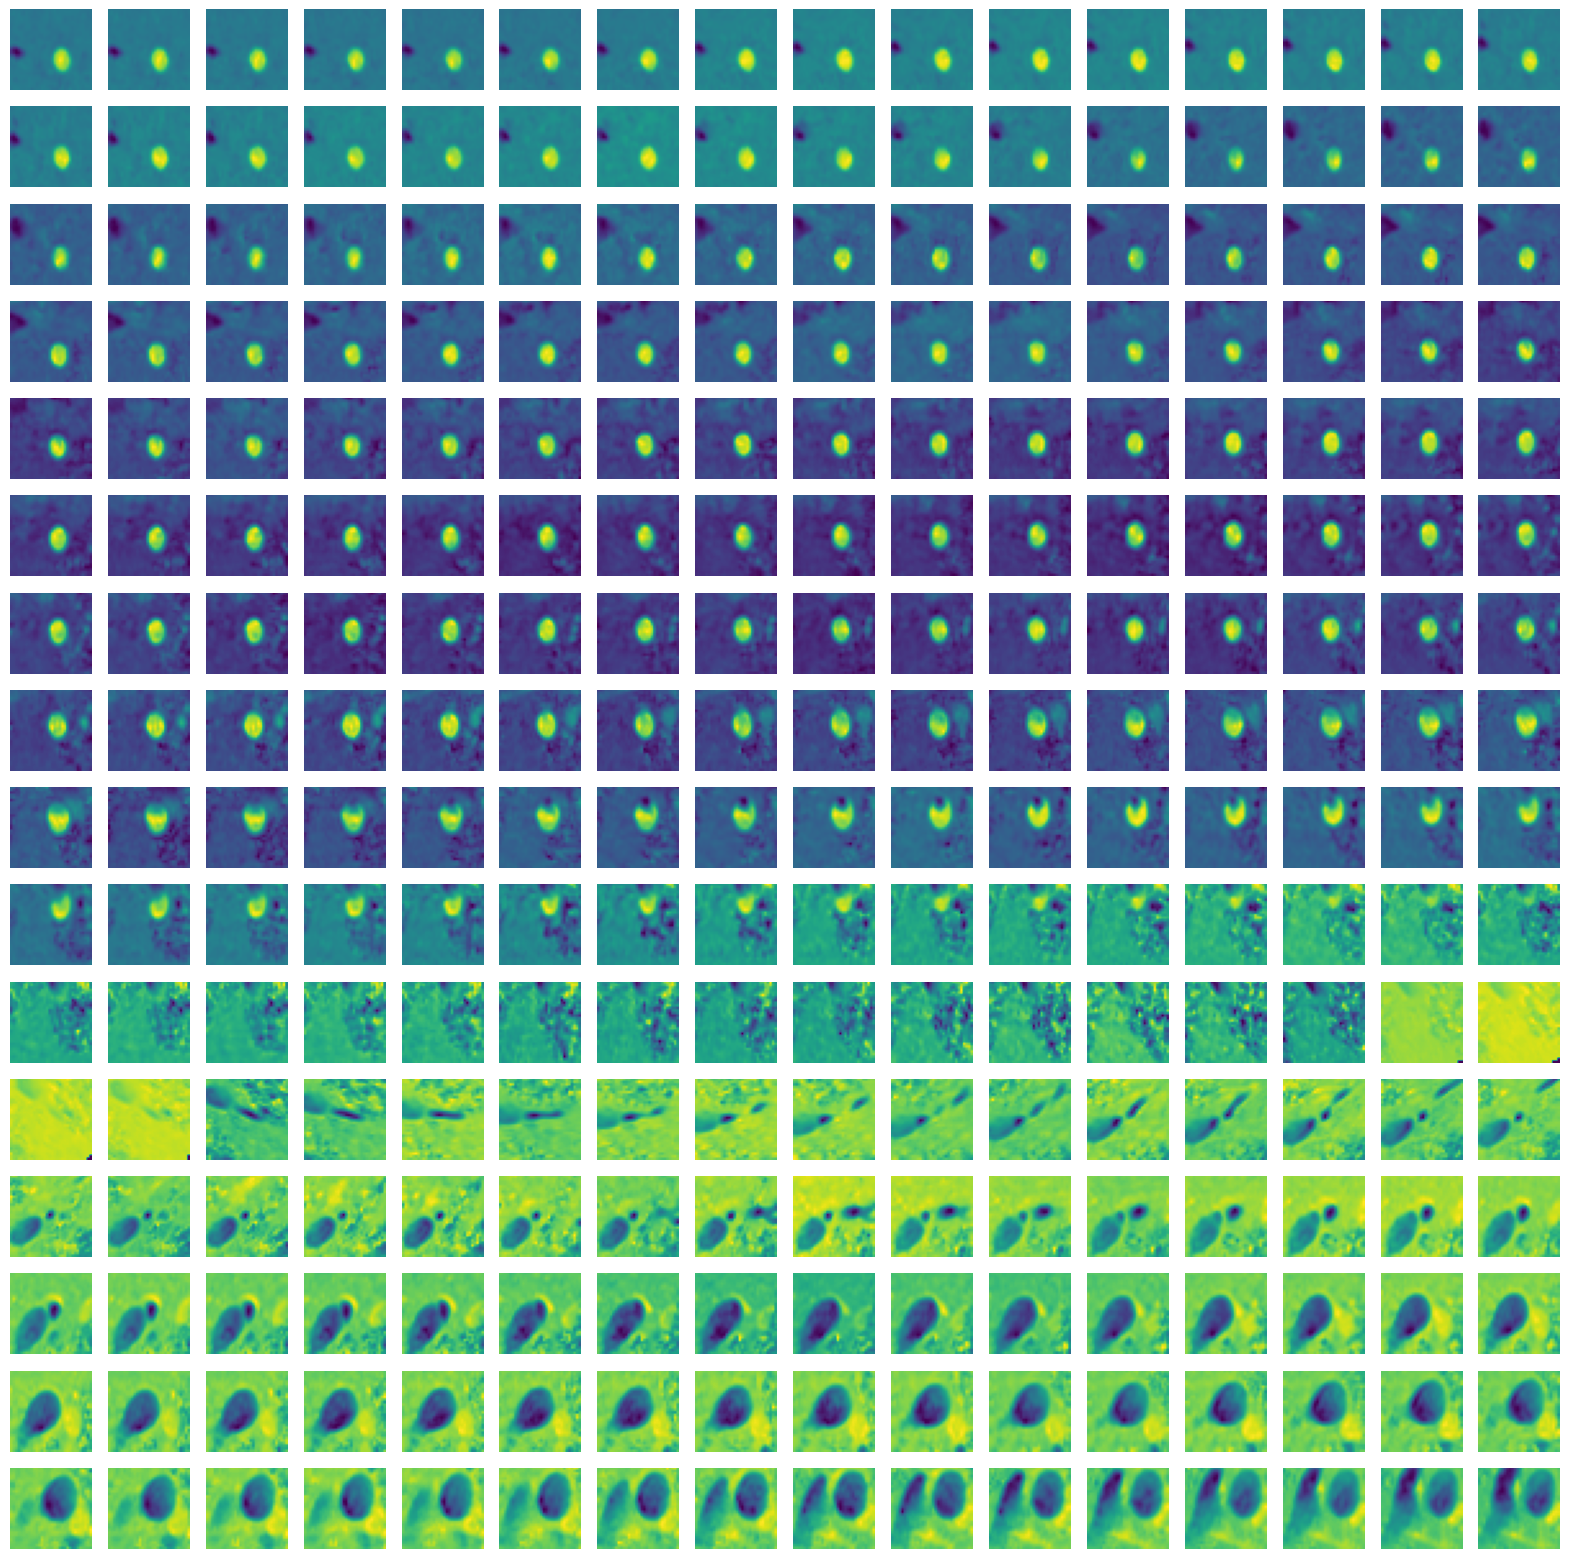

In [97]:
%matplotlib inline
n = 0
fig, axs = plt.subplots(16,16, figsize=(20,20))
ax = axs.ravel()
for i in range(256):

    ax[i].imshow(full_aorta_images_cropped_sliced[i+ (n*256), :,:, 3,1])
    #ax[i].set_title(i)
    ax[i].axis('off')
plt.show()

### Exploration

In [217]:
control_seg_path = "/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady/segmenter_rw_pw_hard/controls"
control_path = "/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady/preprocessed/controls/numpy"
basepath = "/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady"
print(os.listdir(control_seg_path)), print(os.listdir(control_path))

['seg_MACDAVD_101_.npy', 'seg_MACDAVD_102_.npy', 'seg_MACDAVD_103_.npy', 'seg_MACDAVD_104_.npy', 'seg_MACDAVD_105_.npy', 'seg_MACDAVD_106_.npy', 'seg_MACDAVD_109_.npy', 'seg_MACDAVD_110_.npy', 'seg_MACDAVD_116_.npy', 'seg_MACDAVD_117_.npy', 'seg_MACDAVD_118_.npy', 'seg_MACDAVD_119_.npy', 'seg_MACDAVD_120_.npy', 'seg_MACDAVD_122_.npy', 'seg_MACDAVD_124_.npy', 'seg_MACDAVD_126_.npy', 'seg_MACDAVD_127_.npy', 'seg_MACDAVD_129_.npy', 'seg_MACDAVD_132_.npy', 'seg_MACDAVD_134_.npy', 'seg_MACDAVD_135_.npy', 'seg_MACDAVD_137_.npy', 'seg_MACDAVD_142_.npy', 'seg_MACDAVD_145_.npy', 'seg_MACDAVD_146_.npy', 'seg_MACDAVD_148_.npy', 'seg_MACDAVD_152_.npy']
['MACDAVD_101_.npy', 'MACDAVD_102_.npy', 'MACDAVD_103_.npy', 'MACDAVD_104_.npy', 'MACDAVD_105_.npy', 'MACDAVD_106_.npy', 'MACDAVD_107_.npy', 'MACDAVD_108_.npy', 'MACDAVD_109_.npy', 'MACDAVD_145_.npy', 'MACDAVD_148_.npy', 'MACDAVD_150_.npy', 'MACDAVD_152_.npy', 'MACDAVD_154_.npy', 'MACDAVD_110_.npy', 'MACDAVD_111_.npy', 'MACDAVD_113_.npy', 'MACDAVD_1

(None, None)

In [218]:
img = np.load(os.path.join(control_path, os.listdir(control_path)[0]))
seg = np.load(os.path.join(control_seg_path, os.listdir(control_seg_path)[0]))

#img = np.load("/usr/bmicnas02/data-biwi-01/jeremy_students/previous_work/nicolas/data/freiburg/3/10000000/10000001/image.npy")
#seg = np.load("/usr/bmicnas02/data-biwi-01/jeremy_students/previous_work/nicolas/data/freiburg/3/10000000/10000001/random_walker_prediction.npy")
#model_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_True_full_run_bern_full'
#save_path_pred = model_path + "/results/visualization/Bern_patient_level_prediction/"
#file_name = 'freiburg_model_prediction_105.npy'
#seg = np.load(os.path.join(save_path_pred, file_name))
#img = np.load(os.path.join(control_path, os.listdir(control_path)[4]))

In [219]:
img.shape, seg.shape

((160, 110, 56, 23, 4), (160, 110, 56, 23))

In [220]:
try:
    debug_in = img
    debug_label = seg
    #slice_ = 0
    print(slice_)
    %matplotlib inline
    plt.imshow(debug_in[:, :,slice_, 3,0])
    plt.show()
    plt.imshow(debug_in[:, :,slice_, 3,0])
    plt.imshow(debug_label[:, :,slice_, 3], alpha= 0.1)
    slice_ +=1 
    plt.show()
except:
    pass

##### Masked data 
- I am loading both the Bern data and also some from Freiburg with the original script to make sure I am on track

In [221]:
basepath = "/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady"
#masked_data = h5py.File(basepath + '/size_32_masked_images_from_101_to_104.hdf5','r')
masked_data = load_masked_data(basepath, 40101, 40104, 'train', force_overwrite=False)
images_masked = masked_data['masked_images_train']
labels_masked = masked_data['masked_images_train']

Already preprocessed this configuration. Loading now...


In [222]:


masked_data_fr = h5py.File("/usr/bmicnas02/data-biwi-01/jeremy_students/previous_work/nicolas/data/freiburg/masked_images_from20to26.hdf5",'r')
images_masked_fr = masked_data_fr['masked_images_validation']

In [223]:
images_masked.shape, labels_masked.shape

((160, 144, 112, 48, 4), (160, 144, 112, 48, 4))

In [224]:
import matplotlib
masked_array = np.ma.masked_where(images_masked[:, :,:, 3,1] == 0, images_masked[:, :,:, 3,1])

cmap = matplotlib.cm.viridis  # Can be any colormap that you want after the cm
cmap.set_bad(color='black')


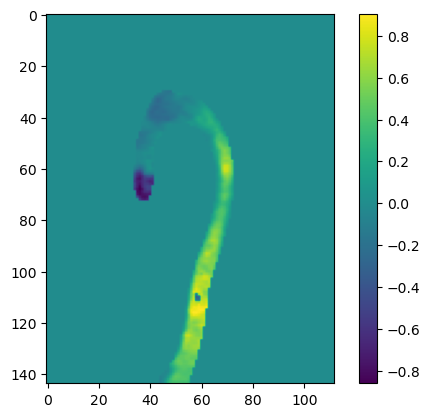

In [225]:
%matplotlib inline
plt.imshow(images_masked[22, :,:, 3,1])
plt.colorbar()
plt.show()

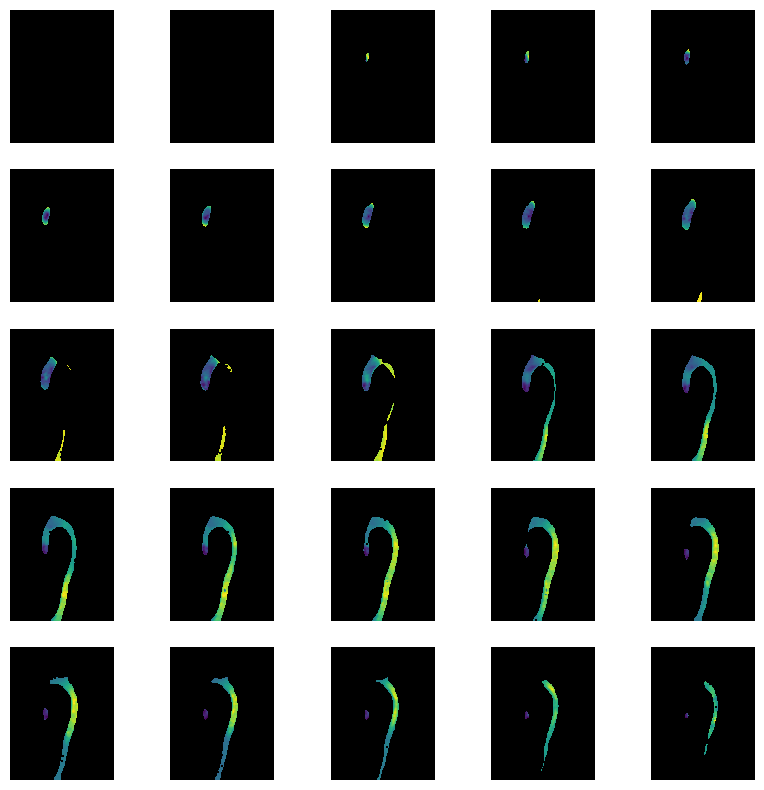

In [226]:

fig, axs = plt.subplots(5,5, figsize=(10,10))
ax = axs.ravel()
for i in range(25):
    ax[i].imshow(masked_array[(i+6), :,:], cmap=cmap)
    #ax[i].set_title(i)
    ax[i].axis('off')

Freiburg


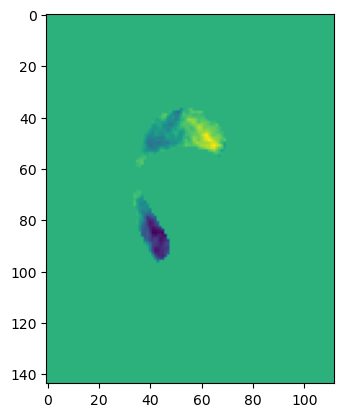

In [227]:
%matplotlib inline
print("Freiburg")
plt.imshow(images_masked_fr[21, :,:, 3,1])
plt.show()

##### Cropped data and sliced orthogonally

In [231]:
cropped_sliced_data = load_cropped_data_sliced(basepath, 9940101, 9940104, 'train', force_overwrite=False)
#cropped_sliced_data = h5py.File(basepath + '/sliced_images_from_101_to_104.hdf5','r')
images_cropped_sliced = cropped_sliced_data['sliced_images_train']
     

Already preprocessed this configuration. Loading now...


In [232]:
cropped_sliced_data_fr = h5py.File("/usr/bmicnas02/data-biwi-01/jeremy_students/previous_work/nicolas/data/freiburg/sliced_images_from20to26.hdf5",'r')
images_cropped_sliced_fr = cropped_sliced_data_fr['sliced_images_validation']

#### Now let's load the masked one and show them side by side

In [233]:
masked_cropped_sliced_data = load_masked_data_sliced(basepath, 9940101, 9940104, 'train', force_overwrite=False)
masked_images_cropped_sliced = masked_cropped_sliced_data['sliced_images_train']

Already preprocessed this configuration. Loading now...


In [234]:
masked_cropped_sliced_data_fr = h5py.File("/usr/bmicnas02/data-biwi-01/jeremy_students/previous_work/nicolas/data/freiburg/masked_sliced_images_from20to26.hdf5",'r')
masked_images_cropped_sliced_fr = masked_cropped_sliced_data_fr['sliced_images_validation']

In [235]:
masked_images_cropped_sliced.shape, images_cropped_sliced.shape, masked_images_cropped_sliced_fr.shape, images_cropped_sliced_fr.shape

((256, 32, 32, 48, 4),
 (256, 32, 32, 48, 4),
 (448, 32, 32, 48, 4),
 (448, 32, 32, 48, 4))

In [236]:

np.where(masked_images_cropped_sliced[:] != 0 )

(array([  0,   0,   0, ..., 255, 255, 255]),
 array([ 9,  9,  9, ..., 21, 21, 21]),
 array([14, 14, 14, ..., 20, 20, 20]),
 array([ 0,  0,  0, ..., 19, 19, 19]),
 array([0, 1, 2, ..., 1, 2, 3]))

In [237]:

np.where(images_cropped_sliced[:] != 0 )

(array([  0,   0,   0, ..., 255, 255, 255]),
 array([ 0,  0,  0, ..., 31, 31, 31]),
 array([ 0,  0,  0, ..., 31, 31, 31]),
 array([ 0,  0,  0, ..., 19, 19, 19]),
 array([0, 1, 2, ..., 1, 2, 3]))

In [238]:
images_cropped_sliced.shape

(256, 32, 32, 48, 4)

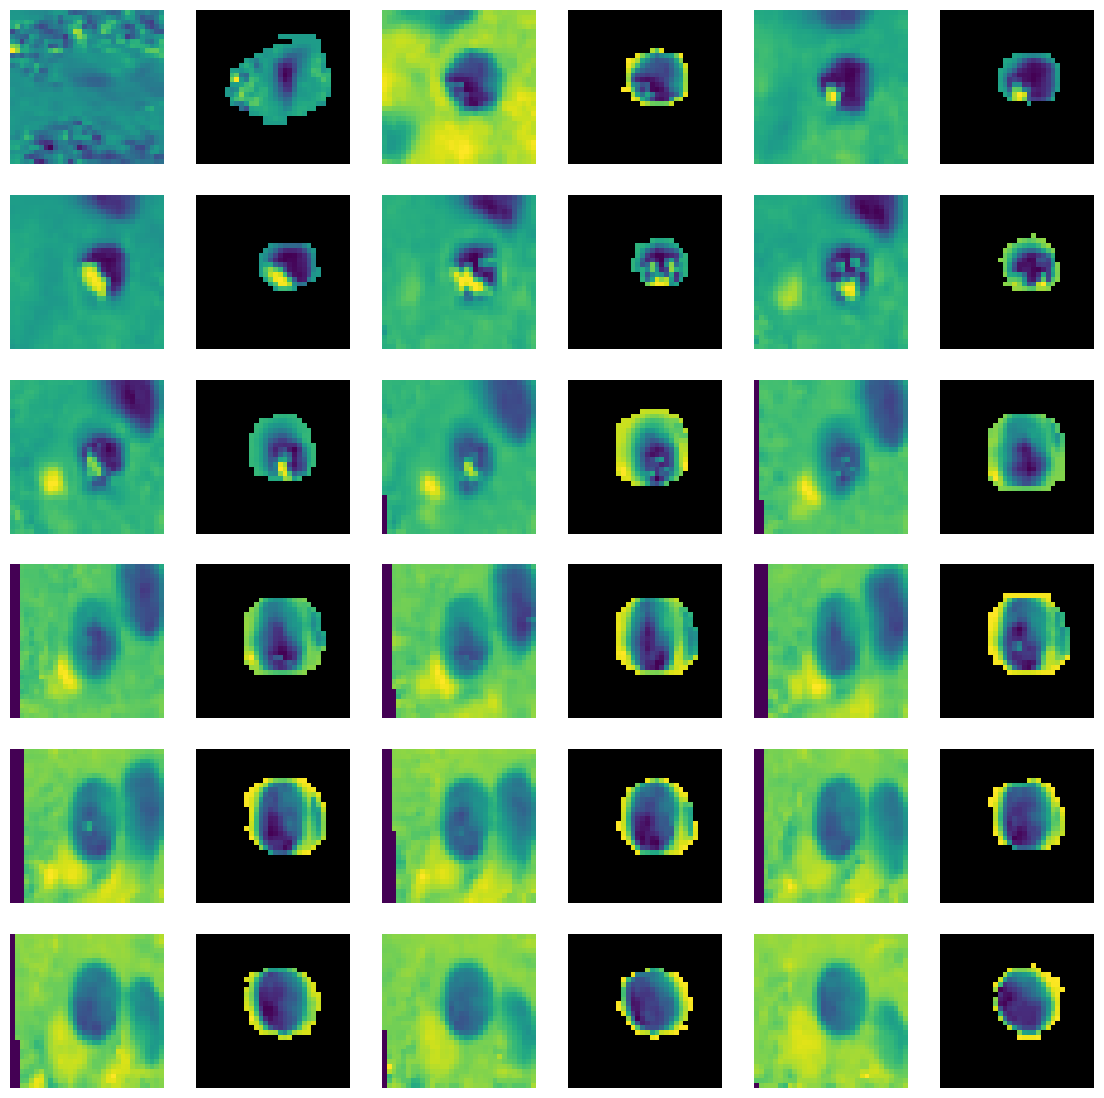

In [239]:
%matplotlib inline
z_slice = 45
z_slices = np.linspace(191,255, 18, dtype=int)
time_slice = 2
channel_slice = 1
fig, axs = plt.subplots(6,6, figsize=(14,14))
ax = axs.ravel()
z_i = 0 
masked_array = np.ma.masked_where(masked_images_cropped_sliced[:, :,:, time_slice,channel_slice] == 0, masked_images_cropped_sliced[:, :,:, time_slice,channel_slice])

cmap = matplotlib.cm.viridis  # Can be any colormap that you want after the cm
cmap.set_bad(color='black')

for i in range(36):
    if i %2 == 0:

        ax[i].imshow(images_cropped_sliced[z_slices[z_i], :,:, time_slice,channel_slice])
    else:
        ax[i].imshow(masked_array[z_slices[z_i], :,:], cmap=cmap)
        z_i +=1
    #ax[i].set_title(i)
    ax[i].axis('off')
#axs[0].imshow(images_cropped_sliced[z_slice, :,:, time_slice,channel_slice])
#axs[1].imshow(masked_images_cropped_sliced[z_slice, :,:, time_slice,channel_slice])
plt.show()

In [245]:
masked_images_cropped_sliced.shape

(256, 32, 32, 48, 4)

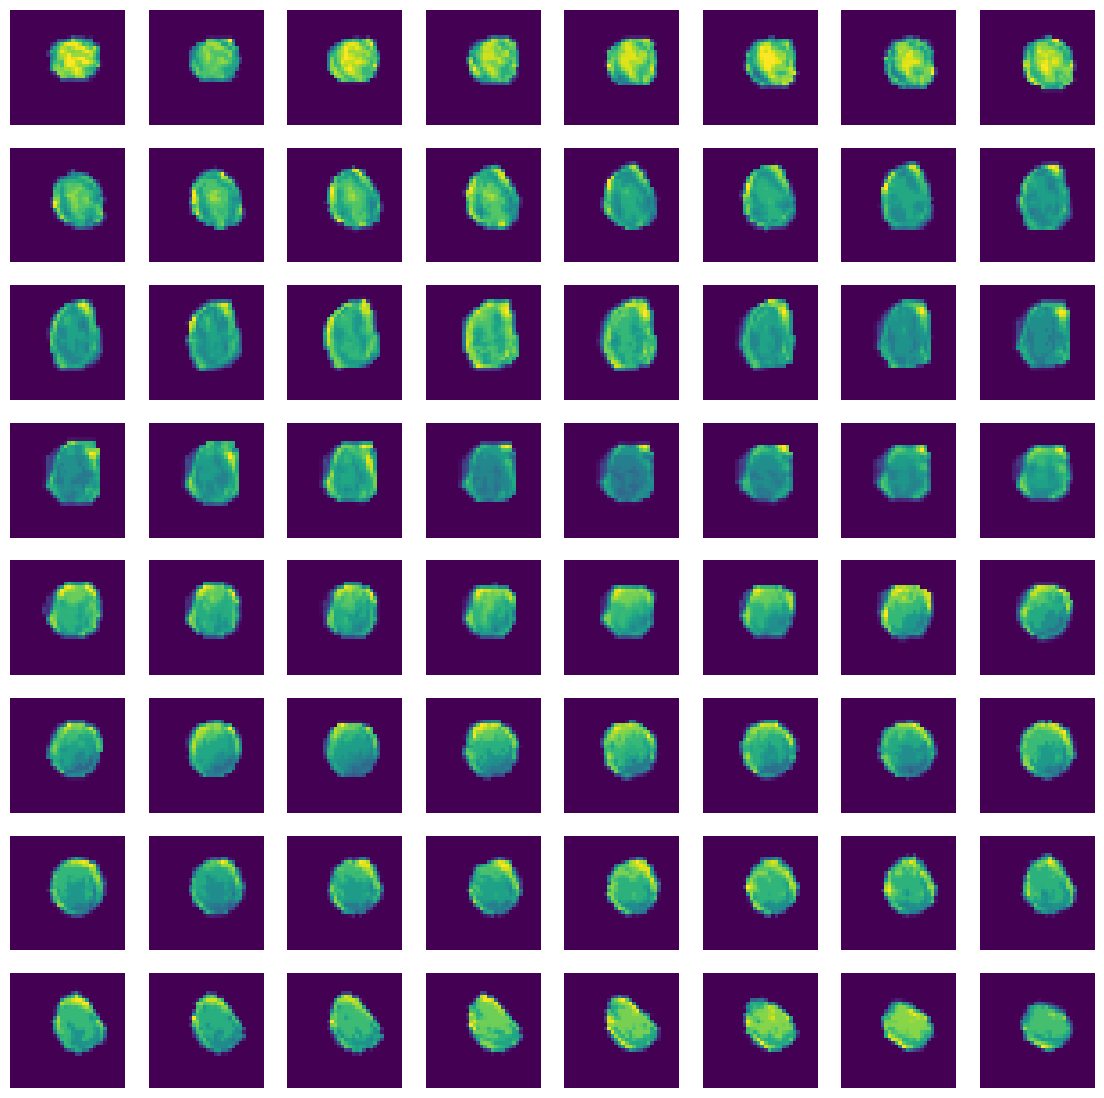

In [248]:
n = 1
fig, axs = plt.subplots(8,8, figsize=(14,14))
ax = axs.ravel()
for i in range(64):
    ax[i].imshow(masked_images_cropped_sliced[i+ (n*64), :,:, 3,0])
    #ax[i].set_title(i)
    ax[i].axis('off')

## Testing centerline for pipeline

In [137]:
%matplotlib inline
import os
import pandas as pd
import h5py
import numpy as np
#import dataset_processing.data_freiburg_subject_ordering as subjects_ordering
#import dataset_processing.config.system as sys_config
from scipy.ndimage import gaussian_filter


import SimpleITK as sitk
import math
from scipy import interpolate

from matplotlib import pyplot as plt
from skimage.morphology import skeletonize_3d, binary_dilation, dilation, cube

from utils import normalize_image


from utils_centerline import (load_masked_data, show_center_lines,load_cropped_data_sliced, 
load_cropped_data_straightened, extract_slice_from_sitk_image, load_masked_data_sliced,
create_center_lines, show_center_lines)

from utils_centerline import load_masked_data_patient, load_cropped_data_sliced_patient, load_masked_data_sliced_patient

In [138]:
model_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/inference_results/unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_False_full_run_finetune_lr_1e-3_e80_AdamW_40_slices_inference_all/controls'
hand_seg_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady/segmenter_rw_pw_hard/controls'

In [139]:
# actually these are the controls one 
all_seg_paths = [os.path.join(hand_seg_path, f) for f in os.listdir(hand_seg_path)]
all_seg_paths = all_seg_paths + [os.path.join(model_path, f) for f in os.listdir(model_path)]
len(all_seg_paths)

82